In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport

import matplotlib 
from matplotlib import pyplot as plt
from matplotlib import style
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image


#nlp
import string
import re    #for regex
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
# Tweet tokenizer does not split at apostophes which is what we want
from nltk.tokenize import TweetTokenizer   


#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [3]:
df=pd.read_excel("malignate_train.xlsx")
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159571 non-null  object
 1   comment_text      159449 non-null  object
 2   malignant         159571 non-null  int64 
 3   highly_malignant  159571 non-null  int64 
 4   rude              159571 non-null  int64 
 5   threat            159571 non-null  int64 
 6   abuse             159571 non-null  int64 
 7   loathe            159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
df['comment_text'] = df['comment_text'].astype(str)

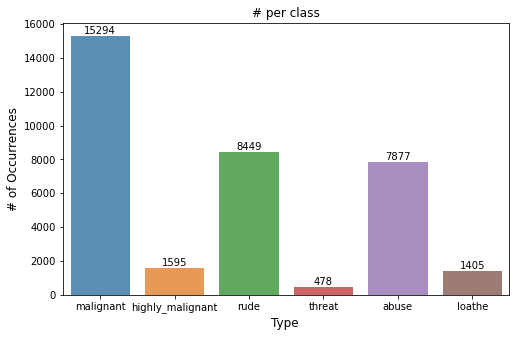

In [304]:
mali=df.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,5))
ax= sns.barplot(mali.index, mali.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = mali.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

In [298]:
df.malignant.value_counts()

0    144277
1     15294
Name: malignant, dtype: int64

In [6]:
# Apply first level cleaning
import re
import string

#This function converts to lower-case, removes square bracket, removes numbers,
#Url's HTML tages and punctuation
def text_clean_1(text):
    text = re.sub('[^a-zA-Z]', ' ', text)    #removing all except english letters 
    text = text.lower()                      #lower case 
    text = re.sub('\[.*?\]', '', text)       #sqare brackets removal  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)   #Removing punctuation
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("https?://\S+|www\.\S+", '', text)                 # Removing Urls
    text = re.sub("<.*?>", '', text)                                #Removing HTMl Tags
    
    return text

cleaned1 = lambda x: text_clean_1(x)
df['comment_text'] = pd.DataFrame(df.comment_text.apply(cleaned1))

In [7]:
# Stopwors 
stop = set(stopwords.words("english"))
stop.add("aww")
stop.add("umm")
stop.add("hey")


print(stop)

{'hey', "couldn't", 'if', 'had', "haven't", 'her', 'while', 'against', 'with', 'that', 'theirs', 't', 'why', 'once', 'should', 'didn', 'will', 'few', 'its', 'in', 'mightn', 'hasn', 'who', 'those', 'under', 'what', 'for', 'having', 'itself', "you'd", 'by', 'no', 'ma', 'it', 'most', 'he', "mustn't", 'his', 'more', 'did', 'don', 'or', 'as', 'ourselves', 'up', "should've", 've', 'o', "aren't", 'been', 'himself', 'umm', 'between', 'isn', "wouldn't", 'myself', "weren't", "she's", 're', 'then', "won't", 'were', 'i', 'before', 'to', 'about', "that'll", 'doesn', 'you', 'this', 'each', 'until', 'on', "it's", 'can', 'below', 'haven', 'very', 'mustn', 'couldn', 'further', 'm', 'weren', 'hers', 'after', 'these', 'hadn', 'wouldn', "hadn't", "shouldn't", 'whom', 'above', 'ain', 'just', "don't", 'wasn', 'll', 'we', 'do', 'are', 'am', "shan't", 'same', 'yourself', 'over', "you'll", 'she', 'some', 'out', 'now', 'yours', 'their', 'at', 'than', 'him', 'nor', 'yourselves', 'aww', 'was', 'there', 'my', 'dow

In [8]:
#Lemmatization of the comments 
from nltk.stem import WordNetLemmatizer
def Lem_txt(text):
    text = text.split()
    ls = WordNetLemmatizer()
    text = [ls.lemmatize(w) for w in text if w not in stop]
    text = " ".join(text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    return text

df.comment_text = df.comment_text.apply(Lem_txt)

In [9]:
df

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,match background colour seemingly stuck thanks...,0,0,0,0,0,0
2,000113f07ec002fd,man really trying edit war guy constantly remo...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,second time asking view completely contradicts...,0,0,0,0,0,0
159567,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer there actual article prostitution ring...,0,0,0,0,0,0
159569,fff125370e4aaaf3,look like actually put speedy first version de...,0,0,0,0,0,0


In [11]:
#Removing columns with more than 500 words
mask = df['comment_text'].str.len() > 3

In [12]:
mask.value_counts()

True     159274
False       297
Name: comment_text, dtype: int64

In [13]:
df2 = df[mask].copy()
df2.reset_index(drop=True,inplace=True)

In [14]:
df2

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,match background colour seemingly stuck thanks...,0,0,0,0,0,0
2,000113f07ec002fd,man really trying edit war guy constantly remo...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159269,ffe987279560d7ff,second time asking view completely contradicts...,0,0,0,0,0,0
159270,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0
159271,ffee36eab5c267c9,spitzer there actual article prostitution ring...,0,0,0,0,0,0
159272,fff125370e4aaaf3,look like actually put speedy first version de...,0,0,0,0,0,0


In [15]:
comm=df2.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=df2.iloc[:,2:].sum(axis=1)
df2['clean']=(rowsums==0)
#count number of clean entries
df2['clean'].sum()
print("Total comments = ",len(df2))
print("Total clean comments = ",df2['clean'].sum())
print("Total tags =",comm.sum())

Total comments =  159274
Total clean comments =  143081
Total tags = 35027


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159274 entries, 0 to 159273
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                159274 non-null  object
 1   comment_text      159274 non-null  object
 2   malignant         159274 non-null  int64 
 3   highly_malignant  159274 non-null  int64 
 4   rude              159274 non-null  int64 
 5   threat            159274 non-null  int64 
 6   abuse             159274 non-null  int64 
 7   loathe            159274 non-null  int64 
 8   clean             159274 non-null  bool  
dtypes: bool(1), int64(6), object(2)
memory usage: 9.9+ MB


In [60]:
sum_column = df2["malignant"] + df2["highly_malignant"] + df2["rude"]+df2["threat"] + df2["abuse"] +df2["loathe"]
df2["sum_column"] = sum_column

In [61]:
df2

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,clean,sum_column
0,0000997932d777bf,"[explanation, edits, made, username, hardcore,...",0,0,0,0,0,0,True,0
1,000103f0d9cfb60f,"[match, background, colour, seemingly, stuck, ...",0,0,0,0,0,0,True,0
2,000113f07ec002fd,"[man, really, trying, edit, war, guy, constant...",0,0,0,0,0,0,True,0
3,0001b41b1c6bb37e,"[make, real, suggestion, improvement, wondered...",0,0,0,0,0,0,True,0
4,0001d958c54c6e35,"[sir, hero, chance, remember, page]",0,0,0,0,0,0,True,0
...,...,...,...,...,...,...,...,...,...,...
159269,ffe987279560d7ff,"[second, time, asking, view, completely, contr...",0,0,0,0,0,0,True,0
159270,ffea4adeee384e90,"[ashamed, horrible, thing, put, talk, page]",0,0,0,0,0,0,True,0
159271,ffee36eab5c267c9,"[spitzer, there, actual, article, prostitution...",0,0,0,0,0,0,True,0
159272,fff125370e4aaaf3,"[look, like, actually, put, speedy, first, ver...",0,0,0,0,0,0,True,0


In [62]:
mask1 = df2['sum_column'] >= 1

In [63]:
df3 = df2[mask1].copy()
df3.reset_index(drop=True,inplace=True)

In [64]:
df3

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,clean,sum_column
0,0002bcb3da6cb337,"[cocksucker, piss, around, work]",1,1,1,0,1,0,False,4
1,0005c987bdfc9d4b,"[talk, exclusive, group, wp, taliban, good, de...",1,0,0,0,0,0,False,1
2,0007e25b2121310b,"[bye, look, come, think, comming, back, tosser]",1,0,0,0,0,0,False,1
3,001810bf8c45bf5f,"[gay, antisemmitian, archangel, white, tiger, ...",1,0,1,0,1,1,False,4
4,00190820581d90ce,"[fuck, filthy, mother, as, dry]",1,0,1,0,1,0,False,3
...,...,...,...,...,...,...,...,...,...,...
16188,fef4cf7ba0012866,"[previous, conversation, fucking, shit, eating...",1,0,1,0,1,1,False,4
16189,ff39a2895fc3b40e,"[mischievious, pubic, hair]",1,0,0,0,1,0,False,2
16190,ffa33d3122b599d6,"[absurd, edits, absurd, edits, great, white, s...",1,0,1,0,1,0,False,3
16191,ffb47123b2d82762,"[listen, ever, delete, edits, ever, annoyed, w...",1,0,0,0,1,0,False,2


In [110]:
df3.comment_text = df3.comment_text.apply(join)


In [70]:
df2.comment_text = df2.comment_text.apply(join)


In [85]:
tox = df3["comment_text"]

In [86]:
unique_words = set()
len_max = 0

for sent in tqdm(tox):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)        

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16193/16193 [00:00<00:00, 38333.65it/s]

30744
1250


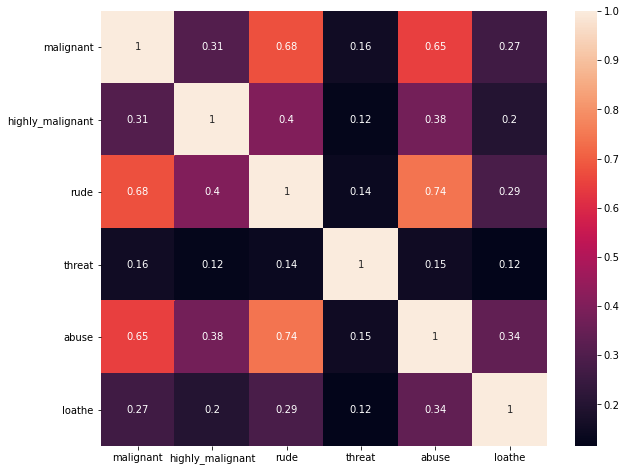

In [151]:
temp_df=df2.iloc[:,2:-2]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

In [77]:
from collections import Counter
cloud = Counter(" ".join(df3["comment_text"]).split()).most_common(20)

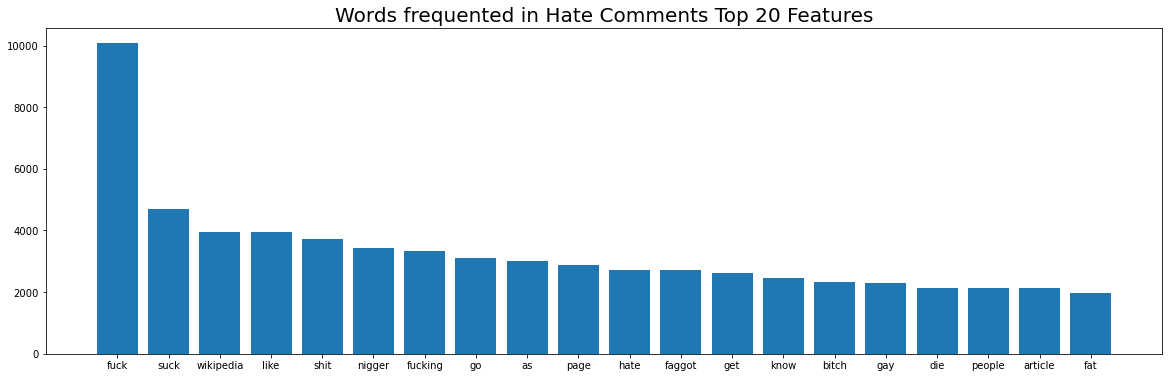

In [150]:
plt.figure(figsize=(20,6))
labels, ys = zip(*cloud)
xs = np.arange(len(labels)) 
plt.bar(xs, ys)
plt.xticks(xs, labels)
plt.title("Words frequented in Hate Comments Top 20 Features", fontsize=20)
plt.show()

In [111]:
from nltk.util import ngrams
text = ' '.join(df3['comment_text'].values)
text_bigrams = [i for i in ngrams(text.split(), 2)]

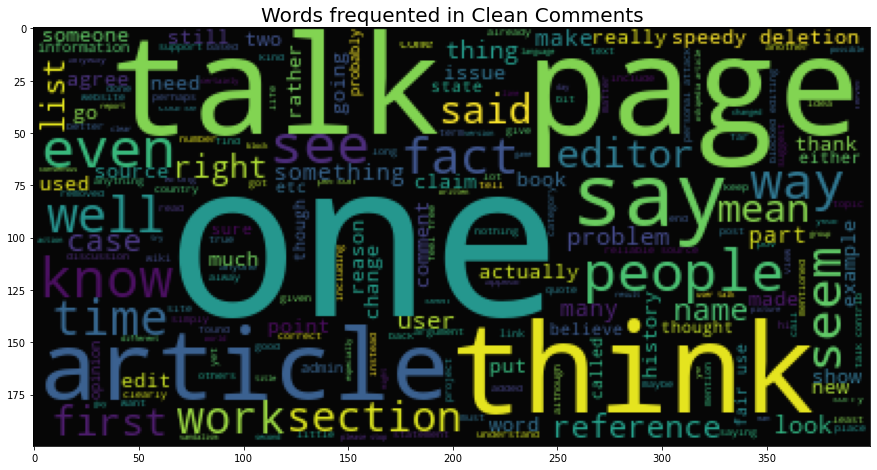

In [71]:
subset=df2[df2.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

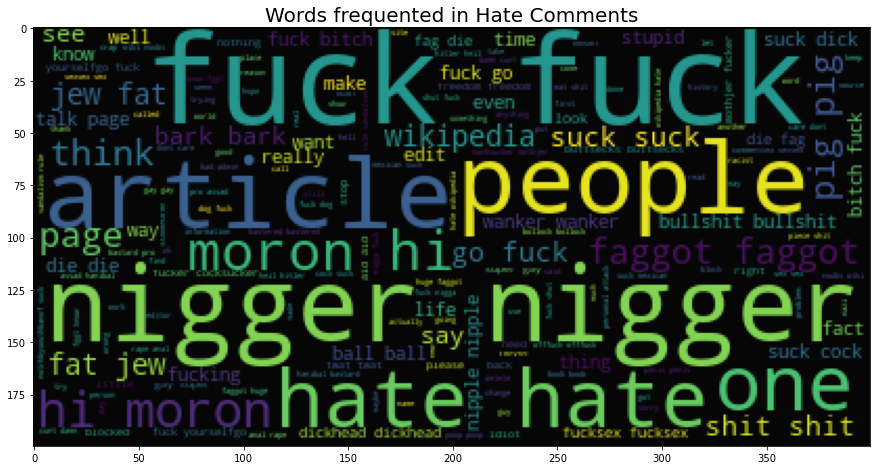

In [69]:
subset=df3
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000)
wc.generate(" ".join(text))
plt.figure(figsize=(15,10))
plt.title("Words frequented in Hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

# Model Building

In [43]:
import keras
import keras.utils
from keras.utils.np_utils import to_categorical
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from tqdm import tqdm
from tensorflow.keras.layers import Bidirectional
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Bidirectional, Activation

In [17]:
def split(text):
    text = text.split()     #Spliting strings into list
    return text
df2.comment_text = df2.comment_text.apply(split)

In [20]:

y_target = df2.iloc[:,2:-1].values
num_classes=y_target.shape[1]

In [21]:
y_target

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

In [22]:
x= df2['comment_text']

In [23]:
x

0         [explanation, edits, made, username, hardcore,...
1         [match, background, colour, seemingly, stuck, ...
2         [man, really, trying, edit, war, guy, constant...
3         [make, real, suggestion, improvement, wondered...
4                       [sir, hero, chance, remember, page]
                                ...                        
159269    [second, time, asking, view, completely, contr...
159270          [ashamed, horrible, thing, put, talk, page]
159271    [spitzer, there, actual, article, prostitution...
159272    [look, like, actually, put, speedy, first, ver...
159273    [really, think, understand, came, idea, bad, r...
Name: comment_text, Length: 159274, dtype: object

In [24]:
#Splitting the data
X_train,X_val,y_train,y_val=train_test_split(x,y_target,test_size=0.33,random_state=15)

In [31]:
#Getting unique words and max length of the string

unique_words = set()
len_max = 0

for sent in tqdm(x):
    
    unique_words.update(sent)
    
    if(len_max<len(sent)):
        len_max = len(sent)
        
#length of the list of unique_words gives the no of unique words
print(len(list(unique_words)))
print(len_max)

100%|██████████████████████████████████████████████████████████████████████| 159274/159274 [00:00<00:00, 296114.67it/s]

158647
1250


In [27]:
max_tokens = 70000
tokenizer = Tokenizer(num_words = max_tokens)
tokenizer.fit_on_texts(x)



# Arguments- texts: list of texts to turn to sequences.
#Return: list of sequences (one per text input).
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)


#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

X_train = sequence.pad_sequences(X_train, maxlen=500)
X_val = sequence.pad_sequences(X_val, maxlen=500)


print(X_train.shape,X_val.shape)

(106713, 500) (52561, 500)


In [28]:
from keras import models
from keras.layers import Dense
from keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

<ipython-input-28-0fbc4dc0198a>:7: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [29]:
## Creating model
embedding_vector_features=20
model=Sequential()
model.add(Embedding(70000,embedding_vector_features,input_length=500))
model.add(LSTM(100))
model.add(Dense(num_classes,activation='sigmoid'))
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy','AUC'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 20)           1400000   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               48400     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 1,449,006
Trainable params: 1,449,006
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
#Fitting the model to the data
hist = model.fit(X_train, y_train, batch_size=128, epochs=2, validation_data=(X_val, y_val))

Epoch 1/2
834/834 [==============================] - 885s 1s/step - loss: 0.3529 - accuracy: 0.9874 - auc: 0.5067 - val_loss: 0.3336 - val_accuracy: 0.9940 - val_auc: 0.5034
Epoch 2/2
834/834 [==============================] - 809s 970ms/step - loss: 0.3302 - accuracy: 0.9940 - auc: 0.5024 - val_loss: 0.3307 - val_accuracy: 0.9938 - val_auc: 0.5031


In [137]:
model.save('model.h5')

In [138]:
load_model = keras.models.load_model('./model.h5')

In [241]:
pred[pred < 0.5] = 0
pred[pred >= 0.5] = 1

# Bidirectional LSTM

In [53]:
model1 = keras.models.Sequential([keras.layers.Input(shape = (500)),
                                    keras.layers.Embedding(70000, 64),
                                    keras.layers.Bidirectional(LSTM(56)),
                                    keras.layers.Dense(128, activation = 'relu'),
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(28, activation = 'relu'),
                                    keras.layers.Dropout(0.1),
                                    keras.layers.Dense(num_classes, activation = 'sigmoid')])
model1.compile(loss='binary_crossentropy',optimizer='SGD',metrics=['accuracy','AUC'])
print(model1.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 64)           4480000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 112)               54208     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               14464     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 28)                3612      
_________________________________________________________________
dropout_7 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                

In [54]:
model1.fit(X_train, y_train, batch_size = 128, epochs = 2, validation_data=(X_val, y_val))

Epoch 1/2
834/834 [==============================] - 2345s 3s/step - loss: 0.5153 - accuracy: 0.1350 - auc: 0.5156 - val_loss: 0.1490 - val_accuracy: 0.9940 - val_auc: 0.6900
Epoch 2/2
834/834 [==============================] - 2366s 3s/step - loss: 0.1547 - accuracy: 0.8166 - auc: 0.6796 - val_loss: 0.1421 - val_accuracy: 0.9940 - val_auc: 0.7479


In [119]:
model1.save('model1.h5')

In [120]:
load_model1 = keras.models.load_model('./model1.h5')

# Test Data

In [31]:
df_test = pd.read_excel("malignate_test.xlsx")
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [32]:
df_test['comment_text'] = df_test['comment_text'].astype(str)

In [33]:
#Text Cleaning
df_test['comment_text'] = pd.DataFrame(df_test.comment_text.apply(cleaned1))
#lemmetization
df_test.comment_text = df_test.comment_text.apply(Lem_txt)

In [34]:
df_test

,id,comment_text
0,00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
1,0000247867823ef7,rfc title fine imo
2,00013b17ad220c46,source zawe ashton lapland
3,00017563c3f7919a,look back source information updated correct f...
4,00017695ad8997eb,anonymously edit article
...,...,...
153159,fffcd0960ee309b5,totally agree stuff nothing long crap
153160,fffd7a9a6eb32c16,throw field home plate get faster throwing cut...
153161,fffda9e8d6fafa9e,okinotorishima category see change agree corre...
153162,fffe8f1340a79fc2,one founding nation eu germany law return quit...


In [35]:
#splitting the text
df_test.comment_text = df_test.comment_text.apply(split)

In [36]:
test_cmnt = df_test["comment_text"]

In [122]:
test_cmnt = tokenizer.texts_to_sequences(test_cmnt)


#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

test_cmnt = sequence.pad_sequences(test_cmnt, maxlen=500)

In [123]:
test_cmnt

array([[    0,     0,     0, ...,    53,   369,    14],
       [    0,     0,     0, ...,   183,   532,  2366],
       [    0,     0,     0, ...,     9, 24954, 51846],
       ...,
       [    0,     0,     0, ..., 15301,   242,  1393],
       [    0,     0,     0, ...,    28,  7669,  2999],
       [    0,     0,     0, ...,   215,    31,  4497]])

In [67]:
#Joining

def join(text):
    text = " ".join(text)
    return text

#df2.comment_text = df2.comment_text.apply(join)

# Logistic Regressor with OneVSRestClassifier

In [145]:
#y=np.array(df2["Rating"].values)
y = df2.iloc[:,2:].values
#x=np.array(df2.drop("Rating", axis=1).values)
x=df2["comment_text"]

In [146]:
cv = CountVectorizer(max_features = 70000)

In [147]:
x = cv.fit_transform(x)
#x = cv.transform(df.Review_title)
print("x.shape = ",x.shape)
print("y.shape = ",y.shape)

x.shape =  (159274, 70000)
y.shape =  (159274, 8)


In [252]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
tfidf = TfidfTransformer()

In [253]:
x = tfidf.fit_transform(x)

In [148]:
#Train test split
train, test = train_test_split(df2, random_state=42, test_size=0.30, shuffle=True)

train_text = train["comment_text"]
test_text = test ["comment_text"]

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode',max_features=70000, analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','comment_text'], axis=1)
x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['id','comment_text'], axis=1)
#print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
#print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

In [142]:
categories = list(df2.iloc[:,2:-2].columns.values)

In [143]:
categories

['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

In [260]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1))])
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction_train = LogReg_pipeline.predict(x_train)
    print('Train accuracy is {}'.format(accuracy_score(train[category], prediction_train)))
    print('Train AUC is {}'.format(metrics.roc_auc_score(train[category], prediction_train)))
    
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test AUC is {}'.format(metrics.roc_auc_score(test[category], prediction)))
    print("\n")


**Processing malignant comments...**
Train accuracy is 0.961324232449256
Train AUC is 0.812330889072716
Test accuracy is 0.9541887282087772
Test AUC is 0.7801472086205209


**Processing highly_malignant comments...**
Train accuracy is 0.9909947888170345
Train AUC is 0.6193022924349617
Test accuracy is 0.9899755143042505
Test AUC is 0.5755698133309619


**Processing rude comments...**
Train accuracy is 0.9797023975029374
Train AUC is 0.8267521654223021
Test accuracy is 0.9752840968545299
Test AUC is 0.7908786955543148


**Processing threat comments...**
Train accuracy is 0.9973361078472702
Train AUC is 0.5496579573967428
Test accuracy is 0.9968817361823242
Test AUC is 0.5261018005074519


**Processing abuse comments...**
Train accuracy is 0.9731996304634455
Train AUC is 0.7694420276336419
Test accuracy is 0.9693405604503694
Test AUC is 0.730895182863145


**Processing loathe comments...**
Train accuracy is 0.9924388515664941
Train AUC is 0.6050712462658399
Test accuracy is 0.99206830881

# XGBClassifier

In [127]:
from xgboost import XGBClassifier
clf = XGBClassifier(use_label_encoder =False,eval_metric='logloss',objective ="binary:logistic")

In [149]:
# Using pipeline for applying XGBClassifier and one vs rest classifier
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    clf.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction_train = clf.predict(x_train)
    print('Train accuracy is {}'.format(accuracy_score(train[category], prediction_train)))
    print('Train AUC is {}'.format(metrics.roc_auc_score(train[category], prediction_train)))
    
    
    # calculating test accuracy
    prediction = clf.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print('Test AUC is {}'.format(metrics.roc_auc_score(test[category], prediction)))
    print("\n")

**Processing malignant comments...**
Train accuracy is 0.963414087235741
Train AUC is 0.8221126058851161
Test accuracy is 0.9551095577925204
Test AUC is 0.7941049616387952


**Processing highly_malignant comments...**
Train accuracy is 0.9950937743853764
Train AUC is 0.7719216666708638
Test accuracy is 0.9895360274574639
Test AUC is 0.5926938782093617


**Processing rude comments...**
Train accuracy is 0.9861872258747343
Train AUC is 0.8930033891865704
Test accuracy is 0.9797417491576502
Test AUC is 0.8529215995643625


**Processing threat comments...**
Train accuracy is 0.9987442932613395
Train AUC is 0.7980916693955245
Test accuracy is 0.9969026641274094
Test AUC is 0.6205791099419682


**Processing abuse comments...**
Train accuracy is 0.9790655747997596
Train AUC is 0.8236016434565269
Test accuracy is 0.9706590209907289
Test AUC is 0.7664129845330303


**Processing loathe comments...**
Train accuracy is 0.9956050264146882
Train AUC is 0.7720054720973976
Test accuracy is 0.992465939

In [153]:
train_seq = df2["comment_text"]
test_seq = df_test["comment_text"]

In [154]:
max_tokens = 70000
tokenizer = Tokenizer(num_words = max_tokens)
tokenizer.fit_on_texts(train_seq)

In [155]:

train_labels = df2[['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']]
# Arguments- texts: list of texts to turn to sequences.
#Return: list of sequences (one per text input).
train_seq = tokenizer.texts_to_sequences(train_seq)



#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.

train_seq = sequence.pad_sequences(train_seq, maxlen=500)



print(train_seq.shape,train_labels.shape)

(159274, 500) (159274, 6)


In [156]:
test_seq = tokenizer.texts_to_sequences(test_seq)
test_seq = sequence.pad_sequences(test_seq, maxlen=500)

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D

# Bidirectional, GlobalMaxPool1D LSTM

In [157]:
tf.keras.backend.clear_session()
input_layer = Input(shape = (500, ))
x = Embedding(70000, 200)(input_layer)
x = LSTM(60, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
output_layer = Dense(6, activation="sigmoid")(x)
model5 = Model(inputs=input_layer, outputs=output_layer)
model5.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 200)          14000000  
_________________________________________________________________
lstm (LSTM)                  (None, 500, 60)           62640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

In [56]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy','AUC','Precision','Recall'])
model4.fit(train_seq, train_labels, batch_size=128, validation_split=0.25, epochs = 2)

Epoch 1/2
934/934 [==============================] - 1406s 1s/step - loss: 0.1752 - accuracy: 0.6685 - auc: 0.7557 - precision: 0.3439 - recall: 0.1262 - val_loss: 0.0525 - val_accuracy: 0.9941 - val_auc: 0.9778 - val_precision: 0.7793 - val_recall: 0.6645
Epoch 2/2
934/934 [==============================] - 1307s 1s/step - loss: 0.0484 - accuracy: 0.9689 - auc: 0.9825 - precision: 0.8064 - recall: 0.6701 - val_loss: 0.0498 - val_accuracy: 0.9940 - val_auc: 0.9798 - val_precision: 0.7921 - val_recall: 0.6727


# Final Model Predictions 

In [46]:
y_pred = model4.predict(test_seq)

In [47]:
y_pred

array([[9.91094947e-01, 2.92352527e-01, 9.39674318e-01, 5.42589426e-02,
        8.52971673e-01, 1.78057939e-01],
       [4.29648161e-03, 2.04376665e-05, 2.68459320e-04, 1.58190727e-04,
        6.77853823e-04, 1.19934200e-04],
       [9.50530171e-03, 5.14087151e-05, 5.95301390e-04, 3.39329243e-04,
        1.62681937e-03, 2.89976597e-04],
       ...,
       [3.14921141e-04, 4.23968800e-07, 1.69871055e-05, 6.14967621e-06,
        3.01346809e-05, 4.69902716e-06],
       [1.54691935e-03, 2.50552148e-06, 1.02231126e-04, 2.53669932e-05,
        1.75446272e-04, 3.05176218e-05],
       [9.77388740e-01, 2.48654187e-02, 8.09110045e-01, 7.95361400e-03,
        5.78339219e-01, 3.42067182e-02]], dtype=float32)

In [48]:
predi = pd.DataFrame(y_pred)

In [159]:
predi

,0,1,2,3,4,5
0,0.991095,2.923525e-01,0.939674,0.054259,0.852972,0.178058
1,0.004296,2.043767e-05,0.000268,0.000158,0.000678,0.000120
2,0.009505,5.140872e-05,0.000595,0.000339,0.001627,0.000290
3,0.000314,3.935850e-07,0.000014,0.000006,0.000028,0.000004
4,0.007155,4.720441e-05,0.000459,0.000294,0.001191,0.000210
...,...,...,...,...,...,...
153159,0.493221,1.360863e-03,0.076300,0.003085,0.118726,0.011376
153160,0.035918,7.192838e-05,0.002163,0.000416,0.005645,0.000989
153161,0.000315,4.239688e-07,0.000017,0.000006,0.000030,0.000005
153162,0.001547,2.505521e-06,0.000102,0.000025,0.000175,0.000031


In [160]:
predi.to_csv('HatePredictions.csv')